In [1]:
import json
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.colors

In [2]:
import scanner

In [3]:
with open('raw/test.jsonl', 'r') as f:
    data = [json.loads(x) for x in f.readlines()]

In [4]:
df = pl.DataFrame(data)

In [5]:
df

acc,sra_egress,fastq_egress,date
str,str,str,str
"""SRR32777074""","""worldwide""","""-""","""2025-03-20"""
"""SRR32766896""","""worldwide""","""-""","""2025-03-20"""
"""SRR32766897""","""worldwide""","""-""","""2025-03-20"""
"""SRR32766898""","""worldwide""","""-""","""2025-03-20"""
"""SRR32766899""","""worldwide""","""-""","""2025-03-20"""
…,…,…,…
"""SRR31397106""","""worldwide""","""-""","""2025-03-20"""
"""SRR31397107""","""worldwide""","""-""","""2025-03-20"""
"""SRR31397108""","""worldwide""","""-""","""2025-03-20"""


In [6]:
len(df.filter(pl.col('sra_egress') == 'worldwide'))

9903

In [7]:
len(df.filter(pl.col('fastq_egress') == 'worldwide'))

339

In [8]:
def get_fastq_only(df):
    return df.filter((pl.col('fastq_egress') == 'worldwide') & (pl.col('sra_egress') != 'worldwide'))

In [9]:
len(get_fastq_only(df))

11

In [10]:
fastq_only = [scanner.NCBIAccessionS3Access.from_acc(acc) for acc in get_fastq_only(df)['acc']]

In [11]:
fastq_only

[NCBIAccessionS3Access(acc='SRR32746355', sra_egress=<FreeEgress.none: '-'>, fastq_egress=<FreeEgress.worldwide: 'worldwide'>, created='2025-03-17 23:18:56'),
 NCBIAccessionS3Access(acc='SRR32231525', sra_egress=<FreeEgress.none: '-'>, fastq_egress=<FreeEgress.worldwide: 'worldwide'>, created='2025-02-04 19:28:38'),
 NCBIAccessionS3Access(acc='SRR31654141', sra_egress=<FreeEgress.none: '-'>, fastq_egress=<FreeEgress.worldwide: 'worldwide'>, created='2024-12-09 20:26:14'),
 NCBIAccessionS3Access(acc='SRR31654142', sra_egress=<FreeEgress.none: '-'>, fastq_egress=<FreeEgress.worldwide: 'worldwide'>, created='2024-12-09 20:28:03'),
 NCBIAccessionS3Access(acc='SRR31654143', sra_egress=<FreeEgress.none: '-'>, fastq_egress=<FreeEgress.worldwide: 'worldwide'>, created='2024-12-09 20:39:13'),
 NCBIAccessionS3Access(acc='SRR31436286', sra_egress=<FreeEgress.none: '-'>, fastq_egress=<FreeEgress.worldwide: 'worldwide'>, created='2024-11-21 14:56:02'),
 NCBIAccessionS3Access(acc='SRR31436287', sra_

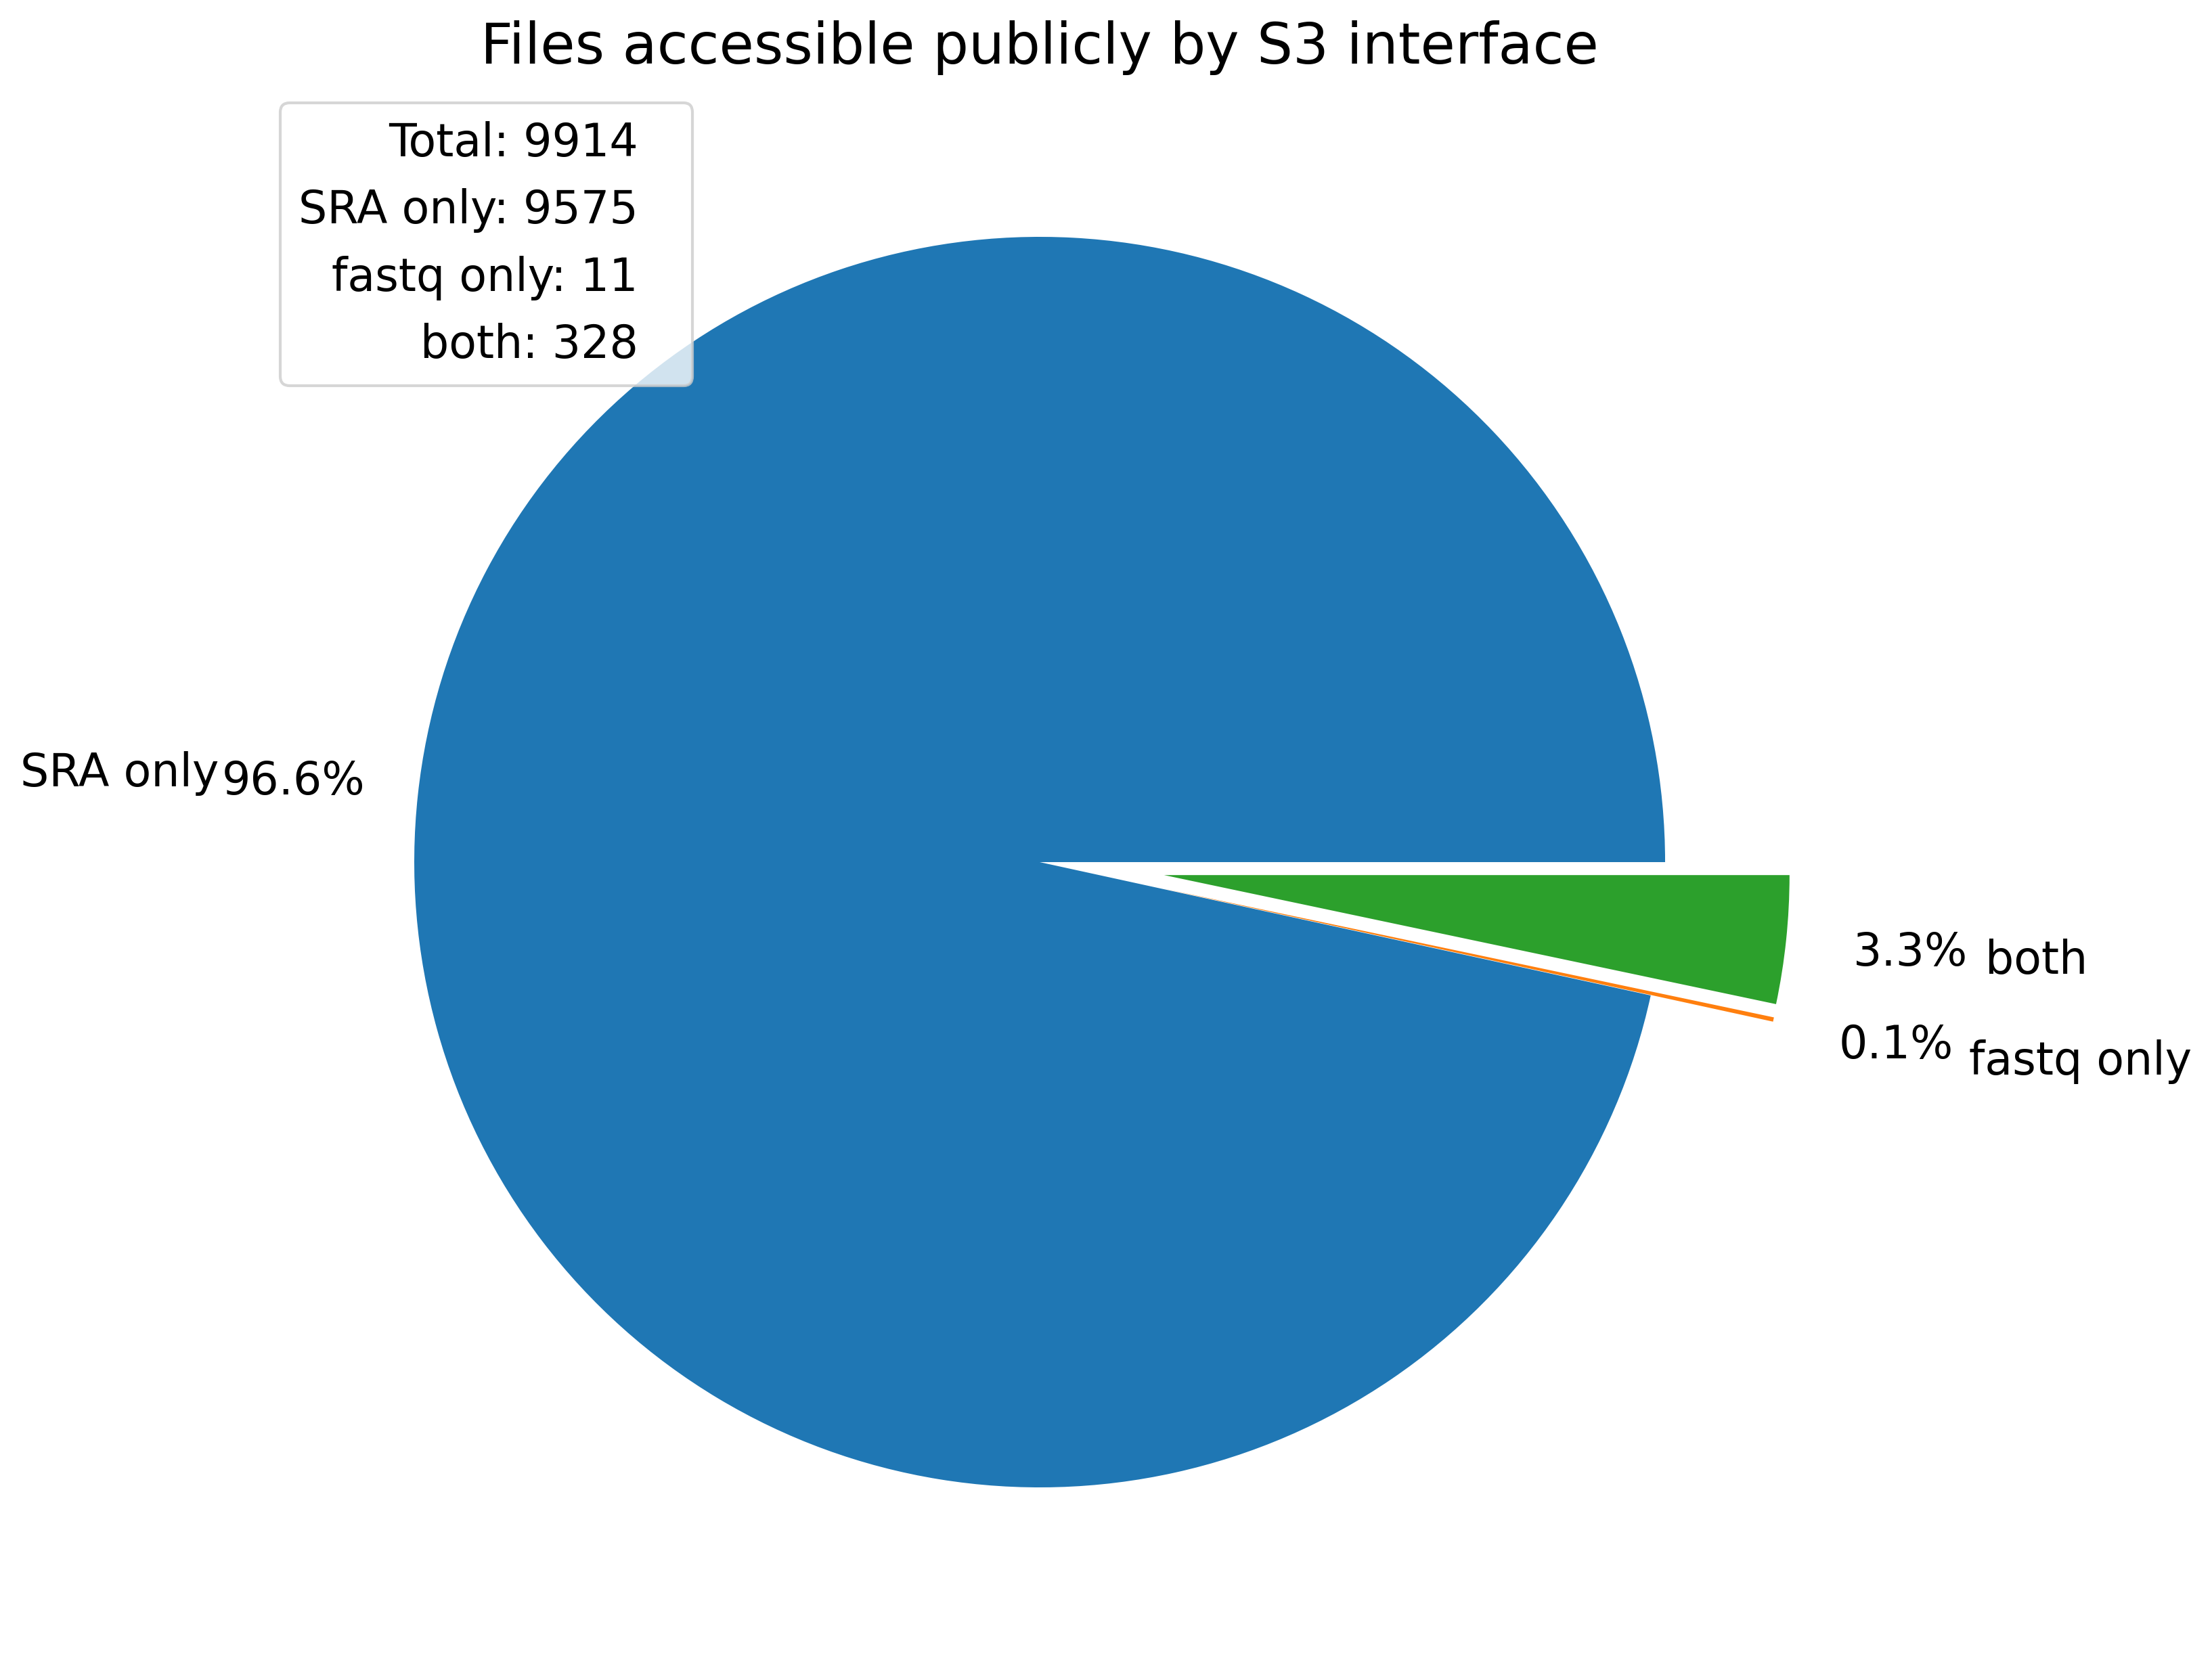

In [12]:
import matplotlib.pyplot as plt

counts = {
    'SRA only': len(df.filter((pl.col('sra_egress') == 'worldwide') & (pl.col('fastq_egress') != 'worldwide'))),
    'fastq only': len(df.filter((pl.col('sra_egress') != 'worldwide') & (pl.col('fastq_egress') == 'worldwide'))),
    'not accessible': len(df.filter((pl.col('sra_egress') != 'worldwide') & (pl.col('fastq_egress') != 'worldwide'))),
    'both': len(df.filter((pl.col('sra_egress') == 'worldwide') & (pl.col('fastq_egress') == 'worldwide'))),
}

total = len(df)

for k in list(counts.keys()):
    if counts[k] == 0:
        del counts[k]
labels = counts.keys()
sizes = [counts[k] for k in labels]

explode = (0, 0.2, 0.2)

fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
ax.pie(
    sizes,
    explode=explode,
    labels=labels,
    autopct='%1.1f%%',
    pctdistance=1.2,
    labeldistance=1.32,
    textprops=dict(
        fontsize=16
    )
)

from matplotlib.patches import Patch
legend_handles = [
    Patch(label=f'Total: {total}', alpha=0),
] + [
    Patch(label=f'{k}: {counts[k]}', alpha=0) for k in counts.keys()
]

ax.set_title(label='Files accessible publicly by S3 interface', fontsize=20)

for handle in legend_handles:
    handle.set_visible(False)

ax.legend(handles=legend_handles, markerfirst=False, handlelength=0, fontsize=16);
plt.savefig('raw_sra_vs_fastq_accessibility.png', bbox_inches='tight')